In [6]:
# !pip install peft

Defaulting to user installation because normal site-packages is not writeable
  Using cached peft-0.10.0-py3-none-any.whl (199 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 KB 7.9 MB/s eta 0:00:0000:01


In [15]:
# !pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/d6/07/061f97211f942101070a46fecd813a6b1bd83590ed7b07c473cabd707fe7/matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/67/0f/6e5b4879594cd1cbb6a2754d9230937be444f404cf07c360c07a10b36aac/contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/67/09/e09ee013d9d6f2f006147e5fc2b4d807eb2931f4f890c2d4f711e10391d7/fonttools-4.51.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms
# https://anirbansen2709.medium.com/finetuning-llms-using-lora-77fb02cbbc48
# https://github.com/microsoft/LoRA/tree/main/examples/NLG
# https://github.com/huggingface/peft


In [1]:
import sys
import gc
import torch
sys.path.append('/home/blatova/lca-solvers/')
from torch.utils.data import DataLoader
from torch.optim import AdamW
import math
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

In [2]:
import random

from transformers import AutoTokenizer, AutoModelForCausalLM

from data_filters.repo_snapshot_filter_stack import SnapshotFilterStack
from data_classes.datapoint_composed import DatapointComposed
from data_loading.raw_train_dataset_loading import DataLoaderTrainRaw
from data_loading.composer_train_dataset_loading import DataLoaderTrainComposed
from context_composers.context_composer_path_distance import ContextComposerPathDistance
from data_classes.datapoint_composed import DatapointComposed
from datasets import load_dataset
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

# NUM_FILES=250

# class ContextComposerTestLength(ContextComposerBase):
#     def __init__(self):
#         super().__init__()
#         pass

#     def compose_context(self, datapoint: DatapointBase, num_files=2) -> str:
#         relevant_context = datapoint.get_relevant_context()
#         non_relevant_context = datapoint.get_non_relevant_context()
#         context =""
#         for i in range(num_files):
#             filename = random.choice(list(relevant_context))
#             content= relevant_context[filename]
#             context=context+f"# {filename}\n\n{content}\n\n"
#         return context

In [3]:
!nvidia-smi

Sun Apr 28 23:07:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   30C    P8              12W / 450W |   6634MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!kill -9 1694536

/bin/bash: line 1: kill: (1694536) - No such process


In [4]:
# loader = DataLoader(cache_dir="/home/blatova/cache_dir")
loader = DataLoaderTrainComposed(
        hf_path='JetBrains-Research/context-py-train',
        hf_config=None,
        cache_dir='/mnt/data2/shared-data/lca/hf_cache2/',
    )
composer = ContextComposerPathDistance()
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("deepseek-ai/deepseek-coder-1.3b-base", trust_remote_code=True, torch_dtype=torch.bfloat16).to("cuda:3")

Resolving data files:   0%|          | 0/124 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Lora parameters

https://medium.com/@manyi.yim/more-about-loraconfig-from-peft-581cf54643db

https://magazine.sebastianraschka.com/p/practical-tips-for-finetuning-llms

https://abvijaykumar.medium.com/fine-tuning-llm-parameter-efficient-fine-tuning-peft-lora-qlora-part-2-d8e23877ac6f

AdaMix Lora: https://arxiv.org/pdf/2210.17451v1

Lora-based mixture of experts: https://arxiv.org/pdf/2404.15159

I believe the modules you've mentioned: gate_proj, down_proj, up_proj, q_proj, v_proj, k_proj, and o_proj, are all linear layers. So, they should be included in the list for LoRA finetuning to get the best results, that compare to full finetuning.

This is based on the QLoRA paper: "We find that the most critical LoRA hyperparameter is how many LoRA adapters are used in total and that LoRA on all linear transformer block layers is required to match full finetuning performance."

To check which layers are linear, you can load the model with the transformers library in Python and then just print(model). The layers to look for will be labeled Linear or Linear4bit if you load the model in 4-bit. While I can't say this is the only way, it's how I've always done it.

For QLoRA finetuning, I've used my own custom script, so I wrote a function that returns a list to simplify the "finding layers to finetune" process. However, keep in mind, this function will work properly only if the model is loaded in 4-bit using the transformers library:

```def find_target_modules(model):
    # Initialize a Set to Store Unique Layers
    unique_layers = set()
    
    # Iterate Over All Named Modules in the Model
    for name, module in model.named_modules():
        # Check if the Module Type Contains 'Linear4bit'
        if "Linear4bit" in str(type(module)):
            # Extract the Type of the Layer
            layer_type = name.split('.')[-1]
            
            # Add the Layer Type to the Set of Unique Layers
            unique_layers.add(layer_type)

    # Return the Set of Unique Layers Converted to a List
    return list(unique_layers)```
From: https://www.reddit.com/r/LocalLLaMA/comments/15sgg4m/what_modules_should_i_target_when_training_using/

```import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))```


Better result about layers and parameters fine-tuning:

https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms : All linear layers

***Other parameters:***

***Optimizer: Commonly used AdamW***

r=16 => alpha = 16 (That’s why the authors set α to the first r and do not tune it. The default of α is 8.)

***r=32 => alpha = 32***

Dropout rate: 

https://ar5iv.labs.arxiv.org/html/2403.00812

https://arxiv.org/pdf/2403.00812

https://arxiv.org/pdf/2404.09610

Hence, we only introduce the dropping in the latter half of layers in decoder-only models and the apparent performance improvement emerges again.

***Dropout rate: Start without dropout? Usually used 0.1 ***

bias: ???




In [5]:
# ds = load_dataset('JetBrains-Research/context-py-train', 'path_distance_relevant', cache_dir = '/mnt/data2/shared-data/lca/hf_cache2/')
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False, r=32, lora_alpha=32, lora_dropout=0.1, target_modules='all-linear'
)

model_lora = get_peft_model(model, peft_config)
model_lora.print_trainable_parameters()
criterion = CrossEntropyLoss()

trainable params: 29,982,720 || all params: 1,376,454,656 || trainable%: 2.178257007545042


In [6]:
#6000 tokens => OOM
ACCUM_STEPS_NUM = 64
CONTEXT_MAX_LEN_CHARS = 5000
CONTEXT_MAX_LEN_TOKENS = 2000

In [7]:
optimizer = AdamW(model_lora.parameters(), lr=5e-5)

In [8]:
def compose_input_sequence(dp: DatapointComposed, max_len: int, context_ratio: float = 0.75) -> str:
    if not -1e8 < context_ratio < 1. + 1e8:
        raise ValueError('context_ratio must be between 0 and 1')
    context = dp.context
    completion = dp.completion

    length_context = int(max_len * context_ratio) + 1
    length_completion = int(max_len * (1 - context_ratio)) + 1

    compl_trim_idx = completion.find('\n', length_completion)
    context_trim_idx = context.rfind('\n', 0, -length_context)

    if compl_trim_idx > 0:
        completion_trimmed = completion[:compl_trim_idx]
    else:
        completion_trimmed = completion

    if context_trim_idx > 0:
        context_trimmed = context[1+context_trim_idx:]
    else:
        context_trimmed = context

    return context_trimmed + completion_trimmed, len(completion_trimmed)

In [9]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def live_plot(data1, data2, figsize=(10, 10), title1='Loss on whole sequence', title2='Loss on completion'):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)  # Creates 2 subplots vertically aligned

    # Plotting data1 on the first subplot
    ax1.plot(data1, marker='o')
    ax1.set_title(title1)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Plotting data2 on the second subplot
    ax2.plot(data2, marker='o')
    ax2.set_title(title2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

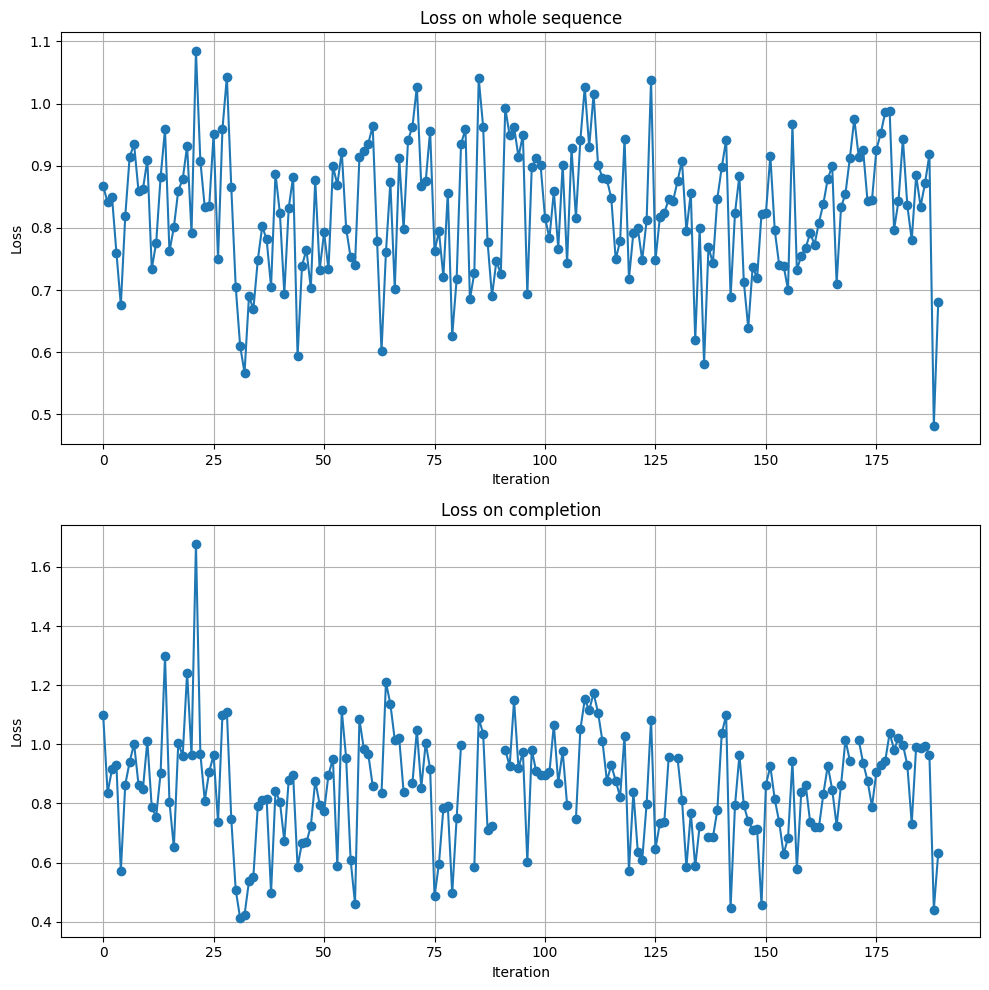

Plotted: 12160 steps


KeyboardInterrupt: 

In [10]:
torch.cuda.empty_cache()
total_whole_input_loss = 0
total_completion_loss = 0
total_tokens = 0
total_completion_tokens = 0
train_losses_whole_input = []
curr_train_loss_whole_input = []
train_losses_completion = []
curr_train_loss_completion = []
for idx, hf_dp in enumerate(loader.get_datapoint_iterator()):
    # torch.cuda.empty_cache()
    # if idx > 20:
    #     break
    
    dp = DatapointComposed.from_hf_datapoint(hf_dp.dp)
    context, completion_length = compose_input_sequence(dp, max_len = CONTEXT_MAX_LEN_CHARS, context_ratio=0.75)
    inputs = tokenizer(context, return_tensors="pt").to(model.device)
    context_inputs = tokenizer(context[:-completion_length])
    context_input_len=len(context_inputs['input_ids'])+1 # +1 is just in case
    inputs['input_ids'] =inputs['input_ids'][:,-CONTEXT_MAX_LEN_TOKENS:]
    inputs['attention_mask'] =inputs['attention_mask'][:,-CONTEXT_MAX_LEN_TOKENS:]
    outputs = model_lora.forward(**inputs)
    logits_size = outputs['logits'].size(-1)
    loss_completion = criterion(outputs['logits'].view(-1, outputs['logits'].size(-1))[context_input_len:-1, :], inputs['input_ids'].view(-1)[context_input_len+1:])
    # print(context_input_len)
    # print(loss.item())
    
    loss_completion.backward()
    detached_logits = outputs['logits'].detach()
    
    # for 0 output logit we have corresponding 1st input
    loss_whole_input = criterion(detached_logits.view(-1, detached_logits.size(-1))[:-1, :], inputs['input_ids'].view(-1)[1:]) 
    
    
    if (idx+1) % ACCUM_STEPS_NUM ==0:
        train_losses_whole_input.append(sum(curr_train_loss_whole_input)/len(curr_train_loss_whole_input))
        train_losses_completion.append(sum(curr_train_loss_completion)/len(curr_train_loss_completion))
        curr_train_loss_whole_input = []
        curr_train_loss_completion=[]
        for param in model_lora.parameters():
            if param.requires_grad:
                if param.grad is not None:
                    param.grad /= ACCUM_STEPS_NUM
        
        optimizer.step()
        optimizer.zero_grad()

    if (idx+1) % (ACCUM_STEPS_NUM*5) ==0:
        live_plot(train_losses_whole_input, train_losses_completion)
        print(f"Plotted: {(idx+1)} steps")
        
    
    curr_train_loss_whole_input.append(loss_whole_input.item())
    curr_train_loss_completion.append(loss_completion.item())
    total_whole_input_loss += loss_whole_input.item() * (inputs['input_ids'].size(0)-1)  # Accumulate scaled loss
    total_completion_loss += loss_completion.item() * (inputs['input_ids'].size(0)- context_input_len -1)  # Accumulate scaled loss
    total_tokens += len(inputs['input_ids']) - 1  # Count tokens processed
    total_completion_tokens += len(inputs['input_ids']) - context_input_len - 1 
    # TODO validation

avg_loss = total_whole_input_loss / total_tokens
perplexity = math.exp(avg_loss)  # Calculate perplexity as exp of the average loss

avg_completion_loss = total_completion_loss / total_completion_tokens
perplexity = math.exp(avg_completion_loss)




    

In [ ]:
# print(len(train_losses))

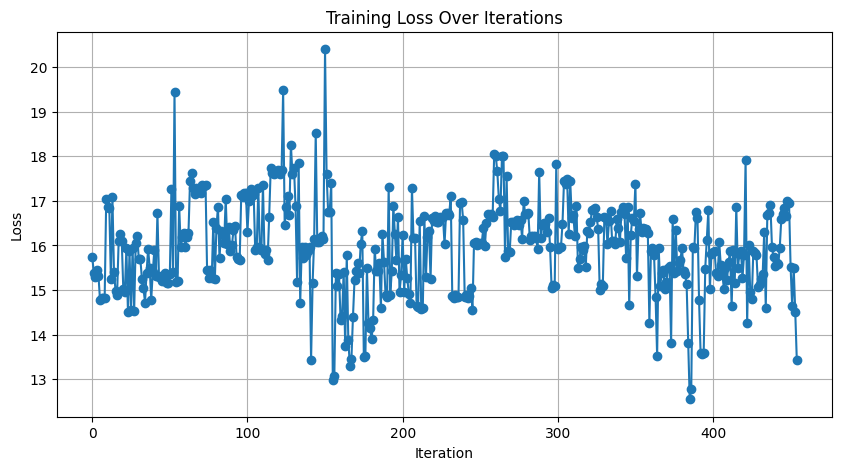

In [10]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, marker='o')
# plt.title('Training Loss Over Iterations')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.show()